<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/behavior/laquitaine_motion_prior_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/projects/behavior/laquitaine_motion_prior_learning.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Study Laquitaine & Gardner motion direction prior learning

author: steeve.laquitaine@epfl.ch

Inpired from [Laquitaine & Gardner, Neuron, 2017](https://www.cell.com/neuron/fulltext/S0896-6273(17)31134-0?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627317311340%3Fshowall%3Dtrue)

Purpose: show how subjects could compute a state prediction error signal and use it to learn the motion directions generative process. We chose a Gaussian generative process for simplicity. Circular distributions like Von Mises distributions are more appropriate for a circular space.






In [ ]:
# @title Dependencies
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import os
import numpy as np
from scipy.stats import norm, uniform
import copy

In [ ]:
# @title Figure settings
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Utils
def build_generative_model(std, mean):
    """create hidden generative process for motion direction
    the experimental Gaussian prior
    """
    # set direction state space
    x = np.arange(1, 360, 1)

    # calculate probability distribution
    pdf = norm.pdf(x, loc=mean, scale=std)
    pdf /= sum(pdf)
    return pdf

def generate_directions(mean, std, n_trials, seed):
    return np.round(norm.rvs(loc=mean, scale=std, size=n_trials, random_state=seed))


def learn_generative_process(motion_directions, learning_rate, x, n_trials):
    """learn the generative process
    """
    # set subject initial belief state
    initial_prior = uniform.pdf(x, loc=x[0], scale=x[-1])
    initial_prior /= sum(initial_prior)
    prior = copy.copy(initial_prior)
    observed = np.zeros((len(x)))
    prediction_errors = []
    priors = []

    for old_trial in range(0, n_trials):

        # locate the observed state component
        state_loc = np.where(x == int(motion_directions[old_trial]))[0][0]

        # compute its state prediction error
        state_pred_error = learning_rate * (1 - prior[state_loc])

        # use the prediction error to update the state belief
        prior[state_loc] = prior[state_loc] + state_pred_error
        prior /= sum(prior)

        # tape
        prediction_errors.append(state_pred_error)
        priors.append(copy.copy(prior))
    return priors

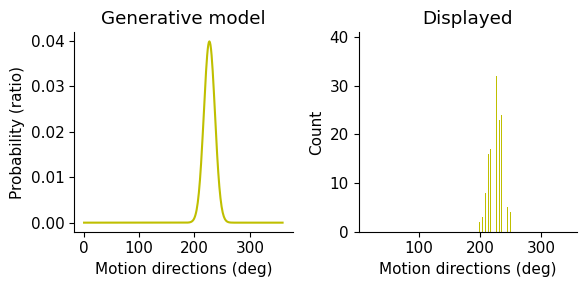

In [ ]:
# @title Create first generative process (10 deg prior)
# set generative model parameters
MEAN = 227
STD = 10
N_TRIALS = 800
SEED = 0

# build generative model
x = np.arange(1, 360, 1)
pdf = build_generative_model(STD, MEAN)

# generate directions
directions_prior01 = generate_directions(mean=MEAN, std=STD, n_trials=N_TRIALS, seed=SEED)

# plot the generative process
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3));
ax1.plot(x, pdf, color=[0.75, 0.75, 0]);
ax1.set_title("Generative model");
ax1.set_ylabel("Probability (ratio)");
ax1.set_xlabel("Motion directions (deg)");

# plot generated motion direction distribution
ax2.hist(directions_prior01, color=[0.75, 0.75, 0], bins=180);
ax2.set_title("Displayed");
ax2.set_xlim([x[0], x[-1]]);
ax2.set_ylabel("Count");
ax2.set_xlabel("Motion directions (deg)");

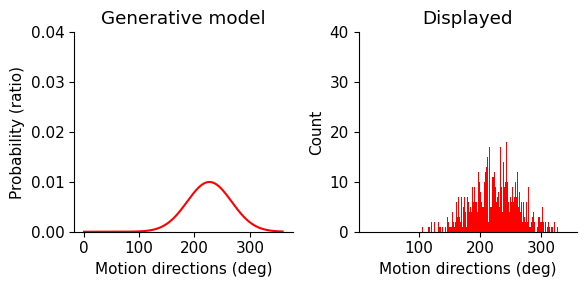

In [ ]:
# @title Create second generative process (40 deg prior)
# set generative model parameters
MEAN = 227
STD = 40
N_TRIALS = 800
SEED = 0

# build generative model
x = np.arange(1, 360, 1)
pdf = build_generative_model(STD, MEAN)

# generate directions
directions_prior02 = generate_directions(mean=MEAN, std=STD, n_trials=N_TRIALS, seed=SEED)

# plot the generative process
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3));
ax1.plot(x, pdf, color=[1, 0, 0]);
ax1.set_ylim([0, 0.04]);
ax1.set_title("Generative model");
ax1.set_ylabel("Probability (ratio)");
ax1.set_xlabel("Motion directions (deg)");

# plot generated motion direction distribution
ax2.hist(directions_prior02, color=[1, 0, 0], bins=180);
ax2.set_ylim([0, 40]);
ax2.set_title("Displayed");
ax2.set_xlim([x[0], x[-1]]);
ax2.set_ylabel("Count");
ax2.set_xlabel("Motion directions (deg)");

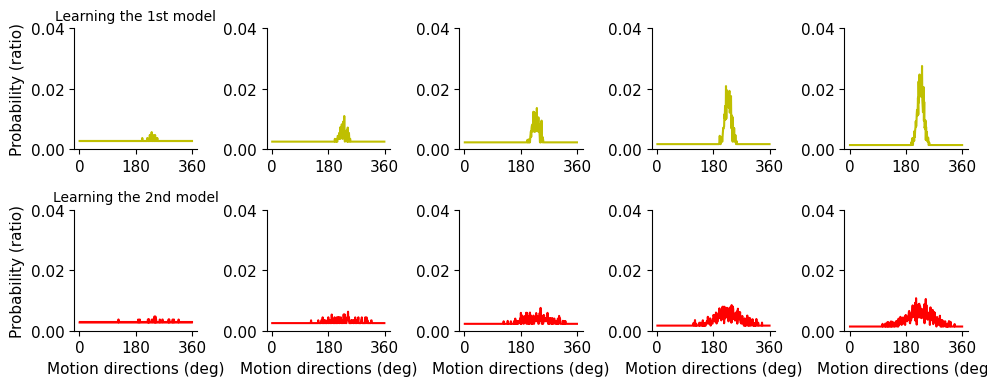

In [ ]:
# @title Prior learning with a state prediction error (SPE)

# create initial prior
initial_prior = uniform.pdf(x, loc=x[0], scale=x[-1])
initial_prior /= sum(initial_prior)

# learn model 1
priors01 = learn_generative_process(directions_prior01, learning_rate=0.001, x=x, n_trials=800)

# learn model 2
priors02 = learn_generative_process(directions_prior02, learning_rate=0.001, x=x, n_trials=800)

# figure
steps = [20, 100, 200, 500, 700]
fig, axes = plt.subplots(2,len(steps), figsize=(10,4))

# plot model 1
axes[0,0].plot(x, initial_prior, color=[0.75, 0.75, 0]);
for ix, step in enumerate(steps):
  axes[0,ix].plot(x, priors01[step], color=[0.75, 0.75, 0]);
  axes[0,ix].set_xticks([0, 180, 360])
  axes[0,ix].set_xticklabels([0, 180, 360])
  axes[0,ix].set_ylim([0, 0.04])
  axes[0,0].set_title("Learning the 1st model", fontsize=10)
  if ix==0:
    axes[0,0].set_ylabel("Probability (ratio)")

# plot model 2
axes[1,0].plot(x, initial_prior, color= [1,0,0]);
for ix, step in enumerate(steps):
  axes[1,ix].plot(x, priors02[step], color= [1,0,0]);
  axes[1,ix].set_xticks([0, 180, 360])
  axes[1,ix].set_xticklabels([0, 180, 360])
  axes[1,ix].set_xlabel("Motion directions (deg)")
  axes[1,ix].set_ylim([0, 0.04])
  axes[1,0].set_title("Learning the 2nd model", fontsize=10)
  if ix==0:
    axes[1,0].set_ylabel("Probability (ratio)")
plt.tight_layout()